# 顔画像データの主成分分析による次元圧縮

## 主成分分析のふまじめな説明

ちゃんとしたことは統計とかデータ分析の教科書などで学んでね．
PIP2020第15回資料にもちょこっとだけ説明があります: https://www-tlab.math.ryukoku.ac.jp/~takataka/course/PIP/PIP2020-15.pdf

$D$ 次元のデータ $ \boldsymbol{x} $ が与えられたときに，その「本質的な情報」を表すより低い次元（$H \le D$ 次元）での表現を求めたい．
主成分分析(Principal Component Analysis, PCA)では，次のような線形変換（直交変換）を考える．

$$
\boldsymbol{y} = U^{\top}(\boldsymbol{x} - \bar{\boldsymbol{x}})
$$

$\bar{\boldsymbol{x}}$ はデータの平均，$U$ は $D\times H$ 行列（各列のベクトルは互いに直交して長さ$1$），$\boldsymbol{y}$ は $H$ 次元ベクトル．

次の変換で $\boldsymbol{y}$ から $D$ 次元ベクトルが得られる．

$$
\boldsymbol{z} = U\boldsymbol{y}
$$

$\boldsymbol{z} + \bar{\boldsymbol{x}}$ は $\boldsymbol{x}$ の近似となる．

## 準備

In [16]:
import numpy as np
import data
import matplotlib.pyplot as plt
import cv2
import ipytools

## 学習データの準備

In [17]:
# データ読み込み準備
d = data.Data()
NL = d.NL  # 学習データの数
NT = d.NT  # テストデータの数

# data/lfw-selected
# NL = 4000, NT = 1721


In [18]:
# 学習データを読み込む
XL = d.get('L').reshape(NL, -1)
_, D = XL.shape
print(D)  # データの次元数

# reading 'L'... (4000, 128, 96, 3)
36864


In [19]:
# 平均を求め，引いておく
Xm = np.mean(XL, axis=0)
XL -= Xm
# 255 で割る → 要素は 0 から 1の値
XL /= 255

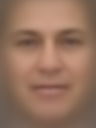

In [20]:
# 平均を可視化
img = Xm.reshape(128, 96, 3)
ipytools.displayImage(img)

## 主成分分析
(データ数) < (次元数) なので，データ行列の SVD 経由で

In [21]:
%%time
# ↑ このセルの実行時間を測る．数分？

# 特異値分解（SVD）
U, sval, Vt = np.linalg.svd(XL, full_matrices=False)
print(U.shape, sval.shape, Vt.shape)

# この問題設定では，得られる特異値は，データの分散共分散行列の固有値に等しい
eva = sval

(4000, 4000) (4000,) (4000, 36864)
CPU times: user 7min 17s, sys: 10.1 s, total: 7min 27s
Wall time: 1min 18s


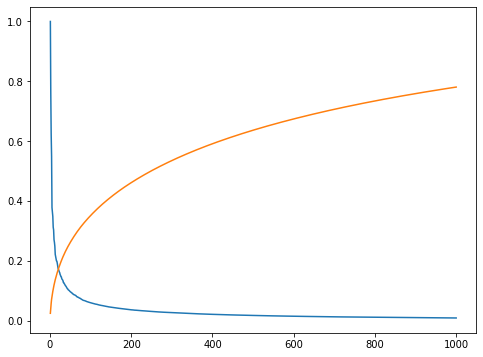

In [22]:
# 固有値のグラフ．最大固有値を 1 としたものと，寄与率

hdim = 1000

fig, ax = plt.subplots(facecolor='white', figsize=(8, 6))
xx = np.arange(hdim, dtype=int) + 1
y1 = eva / eva[0]
y2 = np.cumsum(eva)
y2 /= y2[-1]
ax.plot(xx, y1[:hdim], '-', label = 'y1')
ax.plot(xx, y2[:hdim], '-', label = 'y2')
plt.show()

## 次元圧縮して再構成してみる

In [23]:
hoge1 = np.arange(100, dtype=int)
hoge2 = np.arange(100, 1000, 100, dtype=int)
hoge3 = np.array([1000, 2000, 3000, 4000])
hdimList = np.concatenate((hoge1, hoge2, hoge3))

### 学習データ

In [24]:
%%time

# 主軸変換
Y = XL @ Vt.T
print(Y.shape)

# hdim 番目までの主成分を用いた再構成
sqeL = np.empty(len(hdimList))
for i, hdim in enumerate(hdimList):
    Z = Y[:, :hdim] @ Vt[:hdim, :]
    #print(Z.shape)
    sqeL[i] = np.mean((XL - Z)**2)  # sum ではなく mean => 1画素あたりの二乗誤差になる

(4000, 4000)
CPU times: user 5min 25s, sys: 2min 38s, total: 8min 3s
Wall time: 2min 25s


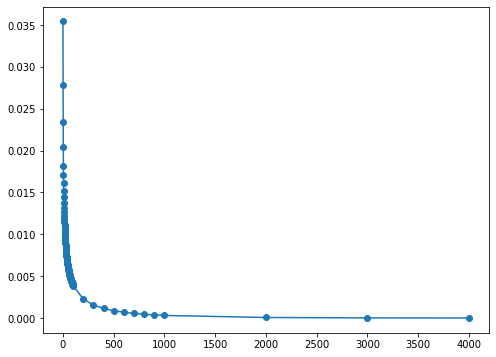

In [25]:
# 二乗誤差のグラフ
fig, ax = plt.subplots(facecolor='white', figsize=(8, 6))
ax.plot(hdimList, sqeL, '-o', label = 'sqeL')
plt.show()

### テストデータ

In [26]:
# テストデータを読み込む
XT = d.get('T').reshape(NT, -1)
XT -= Xm  # 平均を引く
XT /= 255 # 要素を [0,1] にする
print(XT.shape)

# reading 'T'... (1721, 128, 96, 3)
(1721, 36864)


In [27]:
%%time

# 主軸変換
Y = XT @ Vt.T
print(Y.shape)

# hdim 番目までの主成分を用いた再構成
sqeT = np.empty(len(hdimList))
for i, hdim in enumerate(hdimList):
    Z = Y[:, :hdim] @ Vt[:hdim, :]
    #print(Z.shape)
    sqeT[i] = np.mean((XT - Z)**2)  # sum ではなく mean => 1画素あたりの二乗誤差になる

(1721, 4000)
CPU times: user 2min 42s, sys: 13.4 s, total: 2min 55s
Wall time: 43.3 s


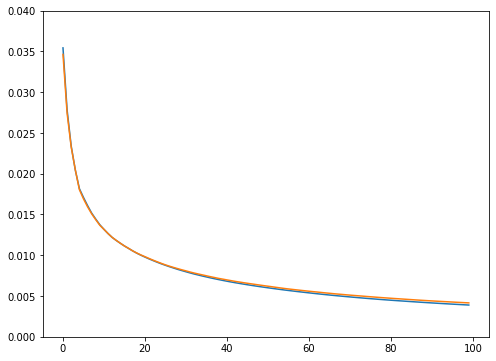

In [28]:
# 二乗誤差のグラフ
fig, ax = plt.subplots(facecolor='white', figsize=(8, 6))
hdim = 100
xx = hdimList[:hdim]
y1 = sqeL[:hdim]
y2 = sqeT[:hdim]
ax.plot(xx, y1, '-', label = 'sqeL')
ax.plot(xx, y2, '-', label = 'sqeT')
ax.set_ylim(0, 0.04)
plt.show()

(16, 36864)
(268, 804, 3)


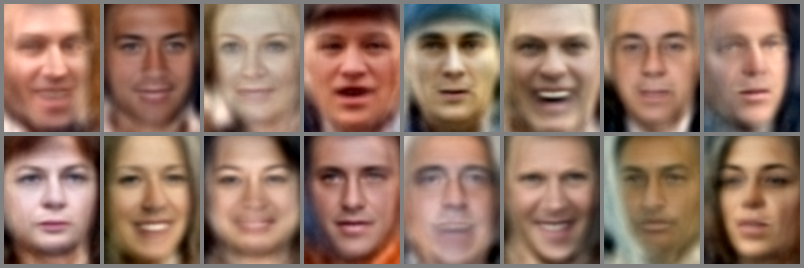

In [29]:
# 再構成したものを可視化する

hdim = 100

ZZ = Y[:16, :hdim] @ Vt[:hdim, :]
ZZ *= 255
ZZ += Xm
print(ZZ.shape)

img = ipytools.mosaicImage(ZZ, 8, 2, nrow=128, ncol=96)
print(img.shape)
ipytools.displayImage(img)

(268, 804, 3)


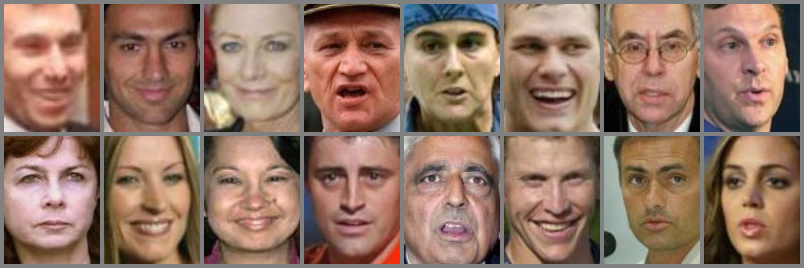

In [30]:
# 元画像
img = ipytools.mosaicImage(XT[:16, :]*255+Xm, 8, 2, nrow=128, ncol=96)
print(img.shape)
ipytools.displayImage(img)